In [ ]:
# Cluster locator
# This program reads extremophile protein alignment FASTA files, obtains the average frequency of
# specified amino acids at particular regions, compares the averages to other organisms, and shows if 
# the differences in protein composition are significant
# Avery Hill
# 11/30/2020

In [ ]:
# clear environment
%reset -f

In [ ]:
%%python3 -m venv ./venv
%%source ./venv/bin/activate

In [ ]:
%pip install -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# FASTA files containing protein sequence data of different types of 
# organisms (e.g psychrophiles, thermophiles, and mesophiles)
infile = ["GEBA-AJS_gyra_align3_psychro.fa", "GEBA-AJS_gyra_align3_meso.fa", "GEBA-AJS_gyra_align3_thermo.fa"]


num_of_files = len(infile)

# Create new files for storing an edited version of the protein sequence data
# which we will use for data analysis
outfile = ["output_data1.fa", "output_data2.fa", "output_data3.fa"]
  
for file_index in range(num_of_files):
    # read in raw FASTA file
    content = open(infile[file_index], "r")
    lines = content.readlines()
    content.close()
    # create new file for edited protein sequence data
    new_file = open(outfile[file_index], "w")
    
    for line in lines:
        if line[0] != '>':
            if line[0] != '\n':
                line = line[:-1]
                new_file.write(line)
        else:
            if line != lines[0]:
                new_file.write('\n')
    new_file.write('\n')
    new_file.close()

In [ ]:
# Adjustable Variables

# Ajust the size of the window. 
# Window size determines how many amino acid the program looks at when calculating the frequency


# Change amino acid


In [ ]:
window_size = 20
amino_acid = "G"

class SlidingWindow:
    def __init__(self, outfile, amino_acid, window_size):
        self.outfile = outfile
        self.amino_acid = amino_acid
        self.window_size = window_size

    def calc_freqs_in_windows(self, sequences):
        seq_window_freqs = np.full(len(sequences), None)
        for seq_idx, seq in enumerate(sequences): # FIXME make numpy ndenumerate() or pandas
            # convert sequence to a series of booleans indicating presence of specified amino acid
            s = pd.Series(np.where(np.array(list(seq))==self.amino_acid, 1, 0))
            # calculate frequencies of each window in the sequence
            sum_in_windows = s.rolling(self.window_size).sum()
            # remove NAs and reset index to 0
            sum_in_windows = sum_in_windows.dropna().reset_index(drop=True) 
            # calculate frequencies
            freqs_in_windows = sum_in_windows / self.window_size
            seq_window_freqs[seq_idx] = freqs_in_windows
        return seq_window_freqs

    def calculate_taxa_freqs(self):
        taxa_window_freqs = np.full(len(self.outfile), None)
        for file_idx, taxa_file in enumerate(self.outfile):
            # read in file(s)
            new_file = open(taxa_file, "r")      
            sequences = new_file.readlines() # FIXME make numpy or pandas structure
            new_file.close()
            # calculate the frequencies in each window of each sequence
            freqs_in_windows = self.calc_freqs_in_windows(sequences)
            taxa_window_freqs[file_idx] = freqs_in_windows
        return taxa_window_freqs

In [ ]:
sw = SlidingWindow(outfile, amino_acid, window_size)
taxa_window_freqs = sw.calculate_taxa_freqs()
print(taxa_window_freqs[0].shape)

In [ ]:
# Put data into a pandas dataframe for easier data analysis
def create_df(taxa_freqs):
    df = pd.DataFrame.from_dict(
        {f"seq_{i}": freq for i, freq in enumerate(taxa_freqs, 1)})
    return df
names = ["psychro", "meso", "thermo"]
taxa_dfs = {name: create_df(taxa) for name, taxa in zip(names, taxa_window_freqs)}

In [ ]:
taxa_dfs["psychro"]

In [ ]:
# Calculate the average amino acid frequency of a sequence
# FIXME is this averaging across rows or columns?
window_freq_means = {name: df.mean(axis = 1) for (name, df) in taxa_dfs.items()} 
# Calculate the variance for each taxa sequence
# FIXME same issue
window_freq_variance = {name: df.var(axis = 1) for (name, df) in taxa_dfs.items()}

In [28]:
window_freq_means = pd.DataFrame(window_freq_means)
window_freq_means

,psychro,meso,thermo
0,0.000000,0.000071,0.0
1,0.000000,0.000142,0.0
2,0.000000,0.000142,0.0
3,0.000000,0.000142,0.0
4,0.000000,0.000142,0.0
...,...,...,...
1735,0.010294,0.003267,0.0
1736,0.010294,0.002912,0.0
1737,0.010294,0.002415,0.0
1738,0.004412,0.001918,0.0


In [ ]:
%pip install plotly

In [16]:
df = pd.DataFrame(window_freq_means)
stacked_df = df.stack()
stacked_df = stacked_df.reset_index()
stacked_df = stacked_df.rename(columns={'level_0':'window','level_1':'taxa', 0:'mean'}) # should match the list order 
stacked_df

,window,taxa,mean
0,0,psychro,0.000000
1,0,meso,0.000071
2,0,thermo,0.000000
3,1,psychro,0.000000
4,1,meso,0.000142
...,...,...,...
5215,1738,meso,0.001918
5216,1738,thermo,0.000000
5217,1739,psychro,0.004412
5218,1739,meso,0.001705


In [ ]:
%pip install nbformat>=4.2.0

In [ ]:
%pip install seaborn

In [ ]:
# Calculate t values for the difference between thermophiles and psychrophiles

# difference = [None] * windows_per_seq
# t_test_values = [None] * windows_per_seq

# for i in range(windows_per_seq):
#     # calculate the mean frequency differences between thermophiles (index 2) and psychrophiles (index 0)
#     difference[i] = window_freq_means[2][i] - window_freq_means[0][i]
#     t_test_values[i] = difference[i] / (np.sqrt((window_freq_variance[2][i]) + (window_freq_variance[0][i])))
    

In [49]:
len(window_freq_means.index), len(window_freq_means['psychro'])

(1740, 1740)

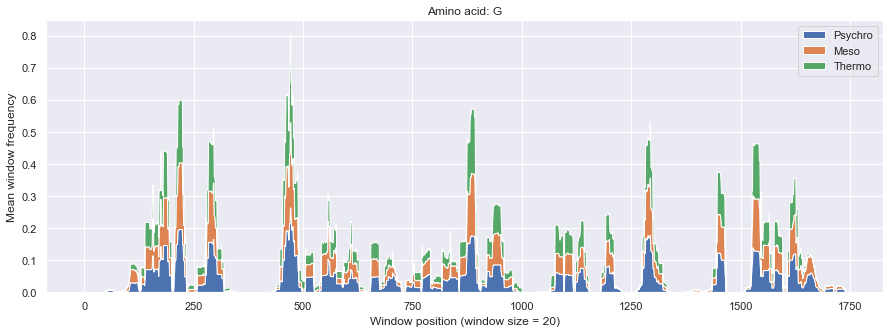

In [64]:
# Plot mean window frequency for each taxa
plt.rcParams['figure.figsize'] = [15, 5]
data_range = range(len(window_freq_means['psychro']))
cols = [window_freq_means[col] for col in window_freq_means]
plt.stackplot(data_range, *cols, labels=window_freq_means.columns)
plt.title(f"Amino acid: {amino_acid}" )
plt.xlabel(f"Window position (window size = {window_size})")
plt.ylabel('Mean window frequency')
plt.legend(["Psychro", "Meso", "Thermo"])


In [56]:
%pip install chart_studio

     |████████████████████████████████| 64 kB 1.7 MB/s 
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached urllib3-1.26.4-py2.py3-none-any.whl (153 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


In [62]:
import chart_studio.plotly as py # interactive graphing
import plotly.graph_objs as go
data_length = len(window_freq_means['psychro'])
traces = [None] * data_length # the series in the graph - one trace for each window
data_range = np.array(range(len(window_freq_means['psychro'])))
for i, taxa in enumerate(window_freq_means):
    traces[i] = go.Bar(x=data_range, y=window_freq_means[taxa], name=taxa)

print(traces)
py.iplot({'data': traces, 'layout': go.Layout(barmode='stack', margin={'b': 150})}, filename='wut')

[Bar({
    'name': 'psychro',
    'x': array([   0,    1,    2, ..., 1737, 1738, 1739]),
    'y': array([0.        , 0.        , 0.        , ..., 0.01029412, 0.00441176,
                0.00441176])
}), Bar({
    'name': 'meso',
    'x': array([   0,    1,    2, ..., 1737, 1738, 1739]),
    'y': array([7.10227273e-05, 1.42045455e-04, 1.42045455e-04, ..., 2.41477273e-03,
                1.91761364e-03, 1.70454545e-03])
}), Bar({
    'name': 'thermo', 'x': array([   0,    1,    2, ..., 1737, 1738, 1739]), 'y': array([0., 0., 0., ..., 0., 0., 0.])
}), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, N

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [None, None, None, None, None, None, None, None, None, None]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [ ]:
# Find where your chosen amino acid clusters are located based on mean frequency!

# Ajust the mean frequency cutoff value
frequency_cutoff = 0.30
print(f"Mean window amino acid frequencies above {frequency_cutoff} are at positions:\n")
for i, mean in enumerate(window_freq_means[0]):
    if mean > frequency_cutoff:
        print(i)

In [ ]:
# Find where your chosen amino acid clusters are located based on t values!

# Ajust the t value cutoff
t_test_cutoff = 1.1
print(f"t-test values above {t_test_cutoff} are at positions:\n")
for i, t_value in enumerate(t_test_values):
    if t_value > t_test_cutoff:
        print(i)

t_test_below = -1 * t_test_cutoff
print(f"t-test values below {t_test_below} are at positions:\n")
for i, t_value in enumerate(t_test_values):
    if t_value < t_test_below:
        print(i)

# 